### Imports

In [108]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import csv

### Setting seeds

In [109]:
torch.manual_seed(42)  # Sets up seed for both devices
np.random.seed(42)
random.seed(42)

### Device

In [110]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


### Loading and transforming data

In [111]:
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Just to make sure
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Train/validation datasets total length

In [112]:
data_set = torchvision.datasets.ImageFolder("data/train/", transform=image_transforms)
len(data_set)  # 88011

88011

In [113]:
batch_size = 32
train_set_size = 70400
valid_set_size = 17611
train_set, validation_set = torch.utils.data.random_split(dataset=data_set, lengths=[train_set_size, valid_set_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.ImageFolder("data/test/", transform=image_transforms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Test dataset length

In [114]:
len(test_set)

10000

Modify labels/targets in test set

In [115]:
print(test_set.imgs[0])

('data/test/test\\00013066837824360356.JPEG', 0)


In [116]:
for i in range(len(test_set)):
    split_path = test_set.imgs[i][0].split('\\')
    test_set.targets[i] = split_path[1]

In [117]:
print(test_set.targets)


['00013066837824360356.JPEG', '00022240850406751722.JPEG', '0004927347689911432.JPEG', '000563265767796084.JPEG', '0006013938786831874.JPEG', '0006399600638603564.JPEG', '0006465730485515353.JPEG', '0007310156969084769.JPEG', '000912032407904162.JPEG', '0009124332639172117.JPEG', '0011255137743835242.JPEG', '0015368674426765594.JPEG', '0015522510526426725.JPEG', '0016476588773381984.JPEG', '0017273893401673623.JPEG', '0017919060529562048.JPEG', '0019043308335561226.JPEG', '0019061561630828727.JPEG', '0019565696841159497.JPEG', '0021928123381425024.JPEG', '002223214863066203.JPEG', '002381433033175284.JPEG', '0024564313592826403.JPEG', '00252503764726697.JPEG', '0026931047075869907.JPEG', '0029134638002292768.JPEG', '0029929765775938977.JPEG', '003039764483954377.JPEG', '0030516179846837854.JPEG', '0031080759870124597.JPEG', '0031311665918588583.JPEG', '0033250594834229874.JPEG', '0034299586028888607.JPEG', '0036158547876422586.JPEG', '0036753022785861456.JPEG', '0037173472850029476.JPE

### Explore data

In [118]:
print(f'Total classes: {len(data_set.classes)}')
print('Class names:')
data_set.classes

Total classes: 50
Class names:


['acoustic',
 'antenna',
 'bacteria',
 'battery',
 'bean',
 'beetle',
 'bicycle',
 'birch',
 'bird',
 'bomb',
 'bread',
 'bridge',
 'camera',
 'carbon',
 'cat',
 'corn',
 'crab',
 'crocodilian',
 'echinoderm',
 'egg',
 'elephant',
 'fish',
 'flower',
 'frog',
 'fungus',
 'gauge',
 'hammer',
 'icecream',
 'kangaroo',
 'memorial',
 'monkey',
 'motor',
 'nest',
 'palm',
 'pizza',
 'pot',
 'printer',
 'saw',
 'snake',
 'spice',
 'spider',
 'spoon',
 'squash',
 'swine',
 'tea',
 'tomato',
 'towel',
 'truck',
 'turtle',
 'worm']

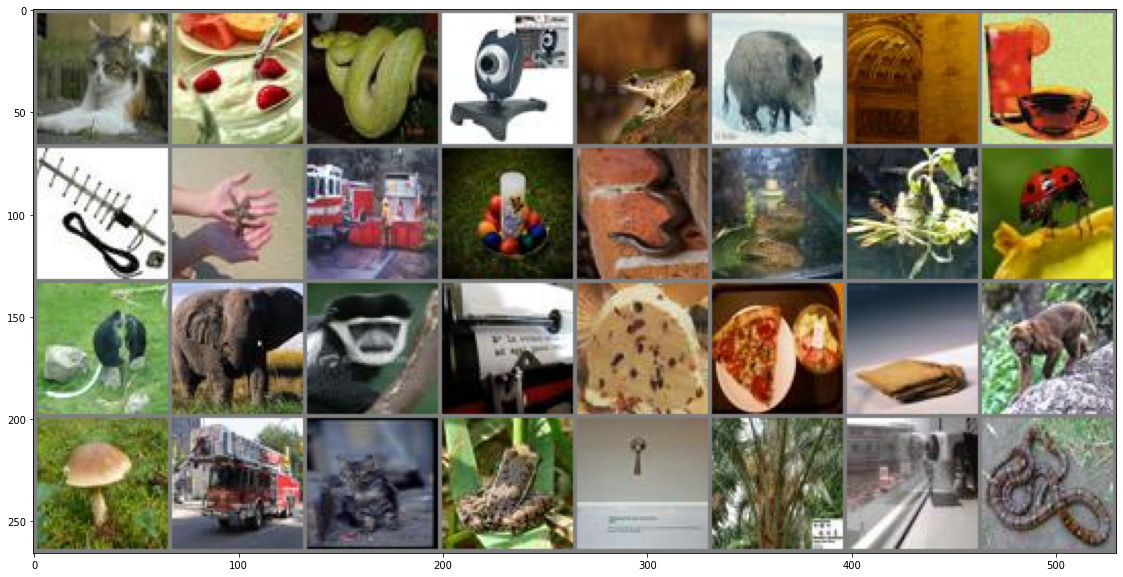

  cat icecream snake camera  frog swine memorial   tea antenna echinoderm truck   egg snake  fish  frog beetle monkey elephant monkey printer icecream pizza bread monkey fungus truck   cat  frog spoon  palm camera snake


In [119]:
plt.figure(figsize=(20, 10))

# Get some random training images
data_iter = iter(train_loader)
images, labels = data_iter.next()


def show_image(img):
    img = img / 2 + 0.5  # Denormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


# show images
show_image(torchvision.utils.make_grid(images))

print(' '.join('%5s' % data_set.classes[labels[j]] for j in range(batch_size)))


Loading random images from validation loader

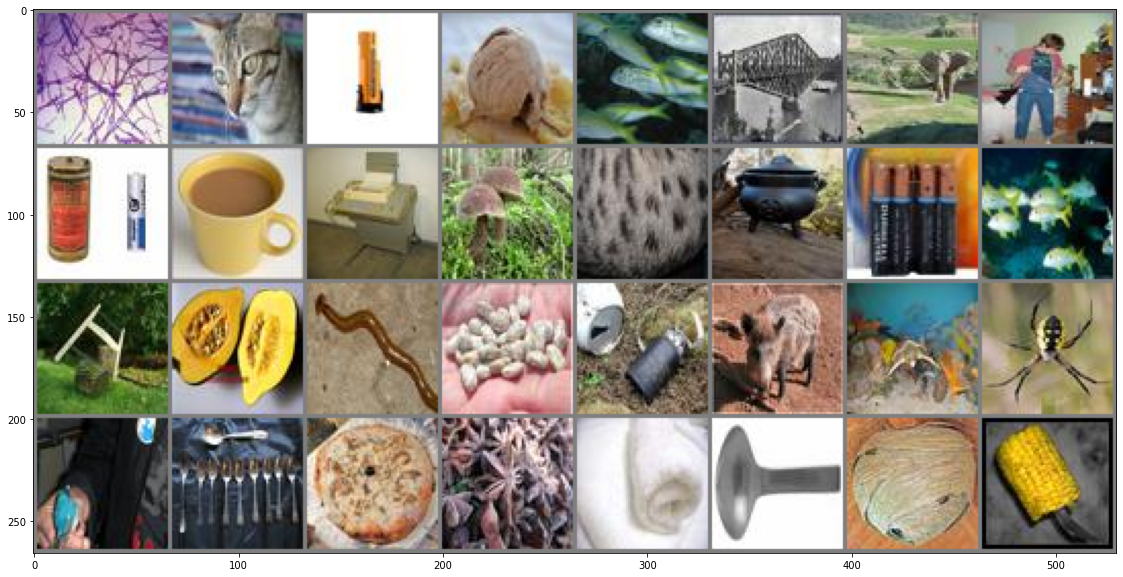

bacteria   cat battery icecream  fish bridge elephant towel battery   tea printer fungus   cat   pot battery  fish   saw squash  worm  bean  bomb swine turtle spider  bird spoon pizza spice towel spoon  nest  corn


In [120]:
plt.figure(figsize=(20, 10))
data_iter = iter(validation_loader)
imgs, labels = next(data_iter)
show_image(torchvision.utils.make_grid(imgs))

print(' '.join('%5s' % data_set.classes[labels[j]] for j in range(batch_size)))

Loading random image from test set

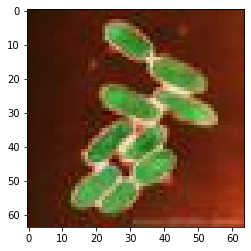

0


In [121]:
img, filename = test_set[5]
show_image(img)
print(filename)

Loading random images from test loader


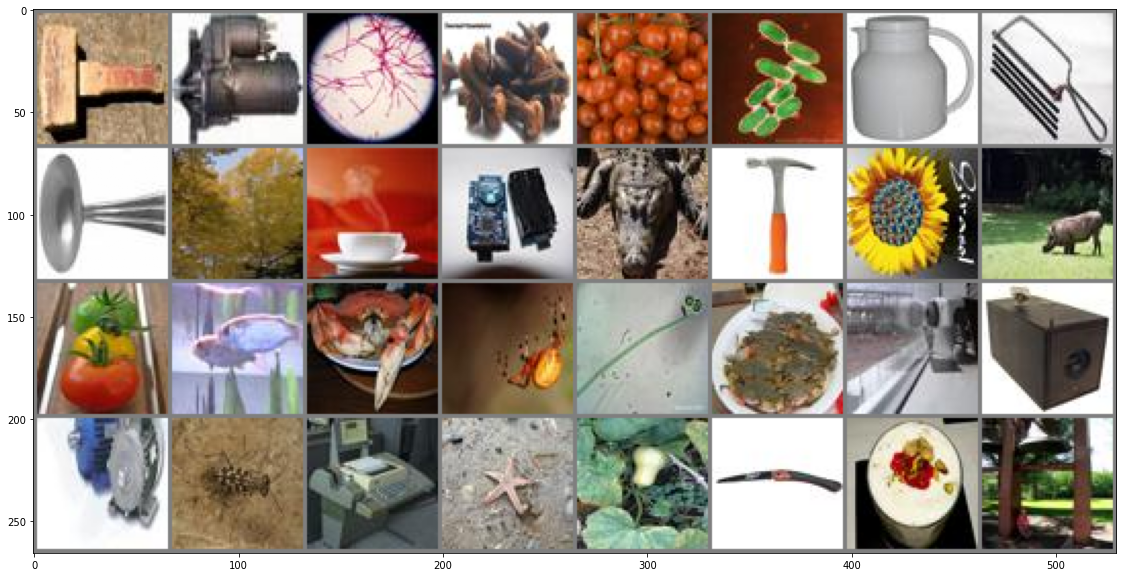

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [122]:
plt.figure(figsize=(20, 10))
data_iter = iter(test_loader)
imgs, labels = next(data_iter)
show_image(torchvision.utils.make_grid(imgs))

print(labels)

Image dimensions

[batch_size, channels, height, width]

Train image size

In [123]:
data_iter = iter(train_loader)
images, _ = data_iter.next()
images[0:1].size()

torch.Size([1, 3, 64, 64])

Validation image size


In [124]:
data_iter = iter(validation_loader)
images, _ = data_iter.next()
images[0:1].size()

torch.Size([1, 3, 64, 64])

Test image size


In [125]:
data_iter = iter(test_loader)
imgs, _ = next(data_iter)
imgs[0:1].size()

torch.Size([1, 3, 64, 64])

### Space for testing input size of dense layer after all convolutions & pooling

In [126]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [127]:
a = images[0:1].to(device)
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), stride=(1, 1), padding=0).to(device)
pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2).to(device)
conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=0).to(device)
pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2).to(device)

a = pool1(conv1(a))
a = pool2(conv2(a))
a = torch.flatten(a, 1)
a.size()

torch.Size([1, 3136])

In [128]:
a = images[0:1].to(device)
conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=3).to(device)
pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1).to(device)

conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1).to(device)
pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1).to(device)

conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1).to(device)
pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=1, padding=1).to(device)

a = pool1(conv1(a))
a = pool2(conv2(a))
a = pool3(conv3(a))
a = torch.flatten(a, 1)
a.size()

torch.Size([1, 12800])

### Some consts


In [129]:
NUM_OF_CLASSES = len(data_set.classes)


### Model definition

After convolution/pooling (no padding) - image size:
W' = ((W - F + 2P) / S) + 1

In [130]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), stride=(1, 1), padding=0)
#         self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
#         self.cb1 = nn.BatchNorm2d(32)
#
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=0)
#         self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
#         self.cb2 = nn.BatchNorm2d(16)
#
#         self.l1 = nn.Linear(3136, 1568)
#         self.b1 = nn.BatchNorm1d(1568)
#         self.d1 = nn.Dropout(0.5)
#
#         self.l2 = nn.Linear(1568, 784)
#         self.b2 = nn.BatchNorm1d(784)
#         self.d2 = nn.Dropout(0.5)
#
#         self.l3 = nn.Linear(784, NUM_OF_CLASSES)
#
#     def forward(self, x):
#         x = self.pool1(torch.relu(self.conv1(x)))
#         x = self.pool2(torch.relu(self.conv2(x)))
#
#         x = torch.flatten(x, 1)  # flatten all dimensions except batch
#
#         x = self.d1(self.b1(torch.relu(self.l1(x))))
#         x = self.d2(self.b2(torch.relu(self.l2(x))))
#         x = self.l3(x)
#         return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        self.cb1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.cb2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=1, padding=1)
        self.cb3 = nn.BatchNorm2d(128)

        self.l1 = nn.Linear(12800, 3200)
        self.b1 = nn.BatchNorm1d(3200)
        self.d1 = nn.Dropout(0.5)

        self.l2 = nn.Linear(3200, 1600)
        self.b2 = nn.BatchNorm1d(1600)
        self.d2 = nn.Dropout(0.5)

        self.l3 = nn.Linear(1600, NUM_OF_CLASSES)

    def forward(self, x):
        x = self.pool1(torch.relu(self.cb1(self.conv1(x))))
        x = self.pool2(torch.relu(self.cb2(self.conv2(x))))
        x = self.pool3(torch.relu(self.cb3(self.conv3(x))))

        x = torch.flatten(x, 1)  # flatten all dimensions except batch

        x = self.d1(self.b1(torch.relu(self.l1(x))))
        x = self.d2(self.b2(torch.relu(self.l2(x))))
        x = self.l3(x)
        return x


net = Net().to(device)
net


Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (cb1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (cb2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=1, dilation=1, ceil_mode=False)
  (cb3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=12800, out_features=3200, bias=True)
  (b1): BatchNorm1d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.5, inplace=False)
  (l2): Linear(in_features=3200

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training


In [132]:
NUM_OF_EPOCHS = 10

In [133]:
min_valid_loss = np.inf
stop_learning = False
for epoch in range(NUM_OF_EPOCHS):

    if stop_learning:
        break

    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # After each epoch check validation loss
    valid_loss = 0.0
    net.eval()
    for data, labels in validation_loader:
        data, labels = data.to(device), labels.to(device)

        val_outputs = net(data)
        loss = criterion(val_outputs, labels)
        valid_loss += loss.item()

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
    # else:
    #     stop_learning = True

    print(f'[{epoch + 1}/{NUM_OF_EPOCHS}] train loss: {running_loss / 2000} | valid loss: {valid_loss / 2000}')

print('Finished Training')

[1/10] train loss: 3.533611346960068 | valid loss: 0.8060706600546836
[2/10] train loss: 2.9699578444361685 | valid loss: 9.11936063504219
[3/10] train loss: 2.7990376600027083 | valid loss: 36.99473317283392
[4/10] train loss: 2.6192923209667205 | valid loss: 17.541995219528676
[5/10] train loss: 2.5617346066236495 | valid loss: 26.66375068694353
[6/10] train loss: 2.367929670870304 | valid loss: 70.75433801692724
[7/10] train loss: 2.311670809328556 | valid loss: 38.47585235768557
[8/10] train loss: 2.2689310982227324 | valid loss: 71.40804487067462
[9/10] train loss: 2.1966025839447973 | valid loss: 50.21128996491432
[10/10] train loss: 2.13332694798708 | valid loss: 31.644595333635806
Finished Training


Saving model

In [134]:
torch.save(net.state_dict(), 'model2.tar')

In [135]:
net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (cb1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (cb2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=1, dilation=1, ceil_mode=False)
  (cb3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=12800, out_features=3200, bias=True)
  (b1): BatchNorm1d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.5, inplace=False)
  (l2): Linear(in_features=3200

### Example - prediction on validation set


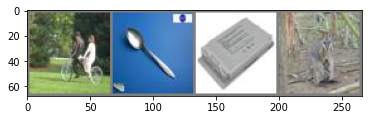

GroundTruth:  bicycle spoon battery kangaroo


In [136]:
data_iter = iter(validation_loader)
images, labels = data_iter.next()
images = images[:4]

show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data_set.classes[labels[j]] for j in range(4)))

In [137]:
outputs = net(images.to(device))
outputs

tensor([[  1.8366,   1.4686,  -0.5401,  -2.9596,  -4.8146,  -2.4994,   3.6612,
           4.0831,   2.1491,   1.0546,  -4.9122,   1.0214,  -2.3628,  -2.0801,
           2.0270,  -2.8180,  -1.8902,   3.8786,  -0.7056,  -3.2442,   5.3460,
           0.4436,  -2.4166,   0.1759,  -1.6274,  -0.4923,  -0.3961,  -4.8151,
           7.8638,   1.8274,   3.6709,  -0.8175,  -0.2931,   2.6632,  -5.4178,
           0.3199,  -3.2594,  -0.1872,  -0.8935,  -4.8322,   1.0600,  -2.4404,
          -1.0946,   4.4903,  -2.4167,  -3.1636,  -0.7441,   1.8754,   0.1940,
          -1.1818],
        [ -1.4454,   2.2552,   1.4599,   0.6618,  -6.9160,  -8.1527,  -2.1670,
          -4.3215,  -3.9491,  -2.5169,  -9.5409,  -0.9607,  -3.3706,  -6.6558,
          -7.1670,  -5.0475,  -2.9117,  -6.3870,  -1.9589,  -8.8790,  -7.1851,
          -2.1997, -10.6174,  -8.5517, -11.2494,   4.6501,   1.3069,  -9.5769,
          -9.8427,  -5.1174,  -7.5628,  -5.7363,  -5.9897,  -6.6596, -13.7980,
          -5.5855,  -2.3664,   0

In [138]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data_set.classes[predicted[j]] for j in range(4)))

Predicted:  kangaroo spoon battery kangaroo


### Testing prediction accuracy on validation set


Total accuracy


In [139]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)

        outputs = net(images).cpu()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # Batch size
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {valid_set_size} validation images: {100 * correct / total} %')

Accuracy of the network on the 17611 validation images: 49.860882403043554 %


Accuracy by class


In [140]:
correct_pred = {classname: 0 for classname in data_set.classes}
total_pred = {classname: 0 for classname in data_set.classes}

with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()
        _, predictions = torch.max(outputs, 1)
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[data_set.classes[label]] += 1
            total_pred[data_set.classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))


Accuracy for class acoustic is: 39.9 %
Accuracy for class antenna is: 45.1 %
Accuracy for class bacteria is: 36.6 %
Accuracy for class battery is: 45.0 %
Accuracy for class bean  is: 30.8 %
Accuracy for class beetle is: 63.5 %
Accuracy for class bicycle is: 73.4 %
Accuracy for class birch is: 54.0 %
Accuracy for class bird  is: 29.4 %
Accuracy for class bomb  is: 45.7 %
Accuracy for class bread is: 43.8 %
Accuracy for class bridge is: 54.2 %
Accuracy for class camera is: 56.4 %
Accuracy for class carbon is: 30.4 %
Accuracy for class cat   is: 57.5 %
Accuracy for class corn  is: 33.3 %
Accuracy for class crab  is: 36.5 %
Accuracy for class crocodilian is: 55.0 %
Accuracy for class echinoderm is: 31.4 %
Accuracy for class egg   is: 35.1 %
Accuracy for class elephant is: 65.5 %
Accuracy for class fish  is: 53.9 %
Accuracy for class flower is: 88.4 %
Accuracy for class frog  is: 39.0 %
Accuracy for class fungus is: 64.0 %
Accuracy for class gauge is: 46.8 %
Accuracy for class hammer is: 70

### Make predictions on test set and save them to csv

In [141]:
with open('predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    i = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = net(images).cpu()
            _, predictions = torch.max(outputs, 1)
            filenames = list()
            for j in range(batch_size):
                filenames.append(test_set.targets[i + j])
            i += j

            for data in zip(filenames, predictions.numpy()):
                writer.writerow(data)
